In [5]:
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras


H5_PATH = "Data/data_burgers_ref.h5"
N_COARSE = 100
CFL = 0.25
SEED = 0
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [6]:
def block_average_1d(u_fine, N_coarse):
    N_fine = u_fine.shape[0]
    assert N_fine % N_coarse == 0
    r = N_fine // N_coarse
    return u_fine.reshape(N_coarse, r).mean(axis=1)

def load_coarse_cases(h5_path, N_coarse, max_cases=None):
    out = []
    with h5py.File(h5_path, "r") as f:
        names = sorted(list(f["cases"].keys()))
        if max_cases is not None:
            names = names[:max_cases]

        for name in names:
            g = f["cases"][name]
            x_f = g["x"][:]
            times = g["times"][:].astype(np.float64)
            U_f = g["U"][:]  # (Nt, N_fine)
            mu = float(g.attrs["mu"])

            N_fine = x_f.shape[0]
            assert N_fine % N_coarse == 0

            a, b = float(x_f.min()), float(x_f.max())
            x_c = np.linspace(a, b, N_coarse, endpoint=False)
            dx = float(x_c[1] - x_c[0])

            U_c = np.stack([block_average_1d(U_f[n], N_coarse) for n in range(U_f.shape[0])], axis=0).astype(np.float64)

            out.append({
                "name": name,
                "x": x_c,
                "dx": dx,
                "times": times,
                "U_ref": U_c,      # coarse-averaged reference
                "mu": mu,
                "domain": (a, b),
            })
    return out

cases = load_coarse_cases(H5_PATH, N_COARSE, max_cases=None)
print("Loaded cases:", len(cases), "| Example mu:", cases[0]["mu"])


Loaded cases: 256 | Example mu: 0.01878985266149949


In [7]:
def f_phys(u):
    return 0.5 * u**2

def rusanov_flux(uL, uR):
    a = np.maximum(np.abs(uL), np.abs(uR))
    return 0.5*(f_phys(uL) + f_phys(uR)) - 0.5*a*(uR - uL)

def nn_flux(model, uL, uR, mu):
    """
    uL,uR: (N,) float64 numpy arrays
    returns: (N,) float64 numpy array of fluxes
    """
    uL32 = uL.astype(np.float32).reshape(-1, 1)
    uR32 = uR.astype(np.float32).reshape(-1, 1)
    logmu = (np.log(mu) * np.ones_like(uL32)).astype(np.float32)
    X = np.concatenate([uL32, uR32, logmu], axis=1)  # (N,3)
    F = model(tf.convert_to_tensor(X)).numpy().reshape(-1).astype(np.float64)
    return F


In [8]:
def laplacian_periodic(u, dx):
    return (np.roll(u, -1) - 2*u + np.roll(u, 1)) / (dx*dx)

def flux_divergence_periodic_from_flux_array(F_iphalf, dx):
    # F_{i+1/2} - F_{i-1/2}
    return (F_iphalf - np.roll(F_iphalf, 1)) / dx

def rhs_fv(u, dx, mu, flux_func, flux_model=None):
    """
    u_t = - d/dx F + mu u_xx
    Convection uses a numerical flux at interfaces i+1/2 computed from (u_i, u_{i+1})
    """
    uL = u
    uR = np.roll(u, -1)
    if flux_func == "rusanov":
        F = rusanov_flux(uL, uR)
    elif flux_func == "nn":
        assert flux_model is not None
        F = nn_flux(flux_model, uL, uR, mu)
    else:
        raise ValueError("flux_func must be 'rusanov' or 'nn'")

    conv = -flux_divergence_periodic_from_flux_array(F, dx)
    diff = mu * laplacian_periodic(u, dx)
    return conv + diff

def ssp_rk3(u, dt, rhs, *rhs_args):
    u1 = u + dt * rhs(u, *rhs_args)
    u2 = 0.75*u + 0.25*(u1 + dt*rhs(u1, *rhs_args))
    u3 = (1/3)*u + (2/3)*(u2 + dt*rhs(u2, *rhs_args))
    return u3

def stable_dt(u, dx, mu, cfl):
    umax = float(np.max(np.abs(u)))
    dt_conv = np.inf if umax == 0.0 else cfl * dx / umax
    dt_diff = np.inf if mu == 0.0 else 0.45 * dx*dx / mu
    return min(dt_conv, dt_diff)

def integrate_to_times(u0, times, dx, mu, flux_func, flux_model=None, cfl=0.25):
    """
    Integrate from times[0] to times[-1] with adaptive substeps so dt respects stability.
    Returns U_pred sampled at exactly `times`.
    """
    u = u0.copy()
    t = float(times[0])
    U_out = [u.copy()]

    for k in range(len(times)-1):
        t_target = float(times[k+1])
        while t < t_target - 1e-15:
            dt = stable_dt(u, dx, mu, cfl)
            dt = min(dt, t_target - t)
            u = ssp_rk3(u, dt, rhs_fv, dx, mu, flux_func, flux_model)
            t += dt

            # hard checks
            if not np.isfinite(u).all():
                raise RuntimeError(f"NaN/Inf detected at t={t:.6f}")
            if np.max(np.abs(u)) > 1e8:
                raise RuntimeError(f"Blow-up detected at t={t:.6f}, max|u|={np.max(np.abs(u)):.3e}")

        U_out.append(u.copy())

    return np.stack(U_out, axis=0)  # shape (Nt, N)


In [9]:
def l1(u, v):   return np.mean(np.abs(u - v))
def l2(u, v):   return np.sqrt(np.mean((u - v)**2))
def linf(u, v): return np.max(np.abs(u - v))

def total_variation(u):
    return np.sum(np.abs(np.roll(u, -1) - u))

def mass(u, L):
    return u.mean() * L

def entropy(u, L):
    # eta(u)=0.5 u^2
    return (0.5*u*u).mean() * L

def evaluate_prediction(U_pred, U_ref, times, x):
    Ldom = float(x.max() - x.min())
    errs = {
        "t": times.copy(),
        "L1": np.array([l1(U_pred[i], U_ref[i]) for i in range(len(times))]),
        "L2": np.array([l2(U_pred[i], U_ref[i]) for i in range(len(times))]),
        "Linf": np.array([linf(U_pred[i], U_ref[i]) for i in range(len(times))]),
        "mass": np.array([mass(U_pred[i], Ldom) for i in range(len(times))]),
        "TV": np.array([total_variation(U_pred[i]) for i in range(len(times))]),
        "entropy": np.array([entropy(U_pred[i], Ldom) for i in range(len(times))]),
    }
    return errs


In [11]:
class NeuralFlux(tf.keras.Model):
    """
    Consistent numerical flux for inviscid Burgers part:
      f_theta = 0.5*(f(uL)+f(uR)) + (uR-uL)*phi_theta(uL,uR,logmu)
    """
    def __init__(self, hidden_sizes=(64, 64), activation="tanh"):
        super().__init__()
        layers = []
        for h in hidden_sizes:
            layers.append(tf.keras.layers.Dense(h, activation=activation))
        layers.append(tf.keras.layers.Dense(1, activation=None))
        self.net = tf.keras.Sequential(layers)

    @staticmethod
    def physical_flux(u):
        return 0.5 * tf.square(u)

    def call(self, X):
        # X: (batch,3) columns: [uL,uR,log(mu)]
        uL = X[:, 0:1]
        uR = X[:, 1:2]
        log_mu = X[:, 2:3]
        phi = self.net(tf.concat([uL, uR, log_mu], axis=1))
        fL = self.physical_flux(uL)
        fR = self.physical_flux(uR)
        return 0.5*(fL + fR) + (uR - uL)*phi



In [13]:
model = NeuralFlux(hidden_sizes=(128, 128), activation="tanh")
optimizer = tf.keras.optimizers.Adam(1e-3)

#model = keras.models.load_model('models/FirstIterate.keras')
#model.summary()

In [14]:
case_idx = 0
data = cases[case_idx]
x = data["x"]
dx = data["dx"]
times = data["times"]
U_ref = data["U_ref"]
mu = data["mu"]

# NN-flux FV
U_nn = integrate_to_times(U_ref[0], times, dx, mu, flux_func="nn", flux_model=model, cfl=CFL)

# Baseline FV (Rusanov)
U_rus = integrate_to_times(U_ref[0], times, dx, mu, flux_func="rusanov", flux_model=None, cfl=CFL)

nn_stats = evaluate_prediction(U_nn, U_ref, times, x)
ru_stats = evaluate_prediction(U_rus, U_ref, times, x)

print("Final-time errors:")
print(f"  NN    : L1={nn_stats['L1'][-1]:.3e}, L2={nn_stats['L2'][-1]:.3e}, Linf={nn_stats['Linf'][-1]:.3e}")
print(f"  Rusanov: L1={ru_stats['L1'][-1]:.3e}, L2={ru_stats['L2'][-1]:.3e}, Linf={ru_stats['Linf'][-1]:.3e}")


Final-time errors:
  NN    : L1=1.568e-02, L2=2.373e-02, Linf=8.037e-02
  Rusanov: L1=1.099e-02, L2=1.574e-02, Linf=5.102e-02


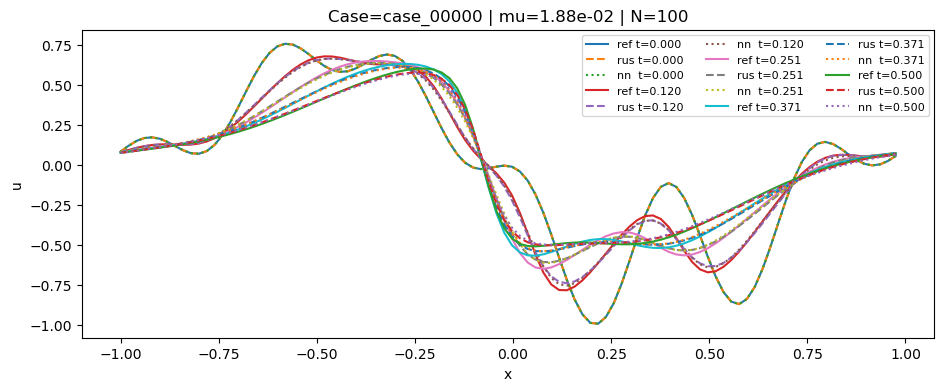

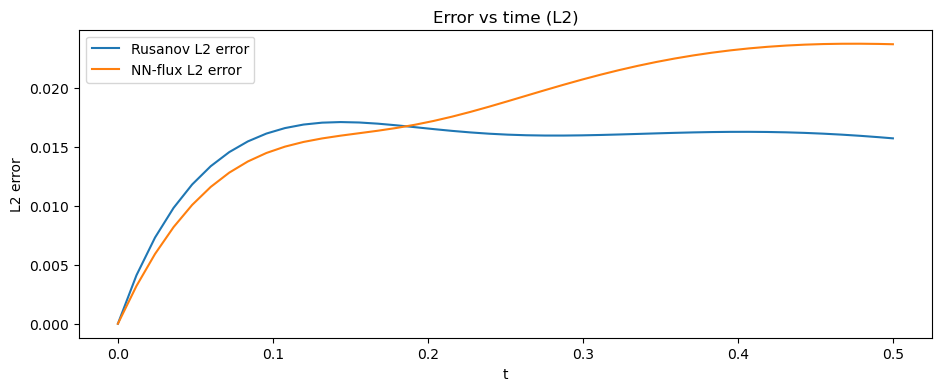

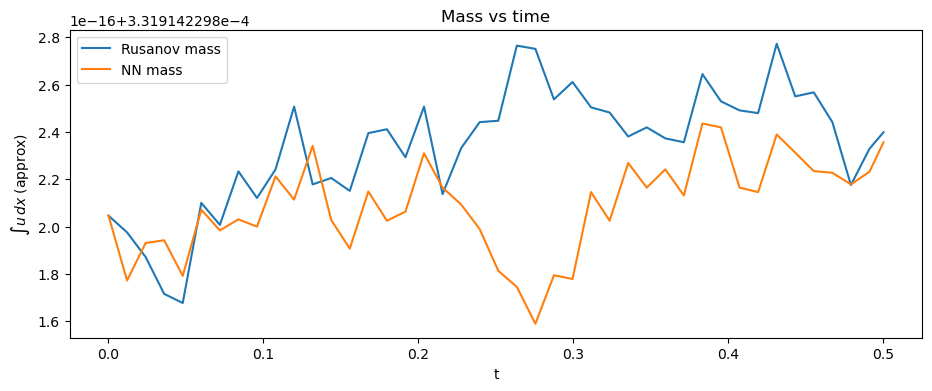

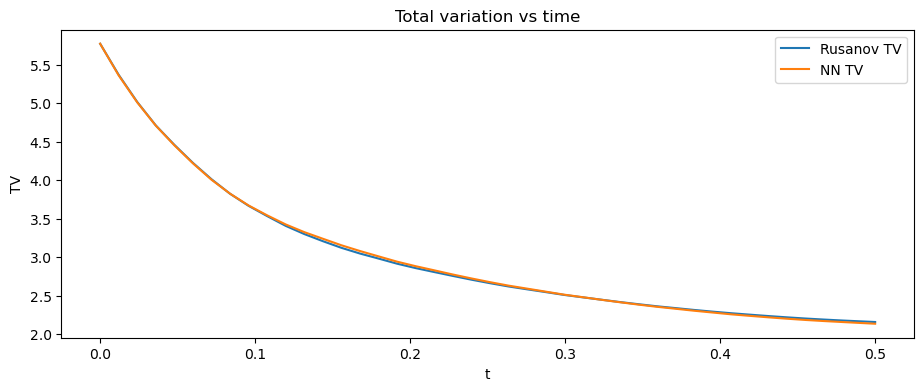

ValueError: 
/\int /\frac12 u^2/\,dx
            ^
ParseSyntaxException: Expected \frac{num}{den}, found '12'  (at char 12), (line:1, col:13)

<Figure size 1100x400 with 1 Axes>

In [17]:
# Choose a few snapshot indices
snap_ids = np.linspace(0, len(times)-1, 5, dtype=int)

plt.figure(figsize=(11, 4))
for k in snap_ids:
    plt.plot(x, U_ref[k], label=f"ref t={times[k]:.3f}")
    plt.plot(x, U_rus[k], linestyle="--", label=f"rus t={times[k]:.3f}")
    plt.plot(x, U_nn[k], linestyle=":", label=f"nn  t={times[k]:.3f}")
plt.title(f"Case={data['name']} | mu={mu:.2e} | N={x.size}")
plt.xlabel("x"); plt.ylabel("u")
plt.legend(fontsize=8, ncol=3)
plt.show()

plt.figure(figsize=(11, 4))
plt.plot(times, ru_stats["L2"], label="Rusanov L2 error")
plt.plot(times, nn_stats["L2"], label="NN-flux L2 error")
plt.title("Error vs time (L2)")
plt.xlabel("t"); plt.ylabel("L2 error")
plt.legend()
plt.show()

plt.figure(figsize=(11, 4))
plt.plot(times, ru_stats["mass"], label="Rusanov mass")
plt.plot(times, nn_stats["mass"], label="NN mass")
plt.title("Mass vs time")
plt.xlabel("t"); plt.ylabel(r"$\int u\,dx$ (approx)")
plt.legend()
plt.show()

plt.figure(figsize=(11, 4))
plt.plot(times, ru_stats["TV"], label="Rusanov TV")
plt.plot(times, nn_stats["TV"], label="NN TV")
plt.title("Total variation vs time")
plt.xlabel("t"); plt.ylabel("TV")
plt.legend()
plt.show()

plt.figure(figsize=(11, 4))
plt.plot(times, ru_stats["entropy"], label="Rusanov entropy")
plt.plot(times, nn_stats["entropy"], label="NN entropy")
plt.title("Entropy (0.5 u^2) vs time")
plt.xlabel("t"); plt.ylabel(r"$/\int /\frac12 u^2/\,dx$ (approx)")
plt.legend()
plt.show()


In [18]:
def evaluate_many(cases, model, max_cases=25):
    rows = []
    for i, data in enumerate(cases[:max_cases]):
        x, dx, times, U_ref, mu = data["x"], data["dx"], data["times"], data["U_ref"], data["mu"]
        try:
            U_nn = integrate_to_times(U_ref[0], times, dx, mu, "nn", model, cfl=CFL)
            nn = evaluate_prediction(U_nn, U_ref, times, x)
            nn_ok = True
        except Exception as e:
            nn_ok = False
            nn = None

        # Baseline (should always be stable)
        U_rus = integrate_to_times(U_ref[0], times, dx, mu, "rusanov", None, cfl=CFL)
        ru = evaluate_prediction(U_rus, U_ref, times, x)

        row = {
            "case": data["name"],
            "mu": mu,
            "rus_L2_final": float(ru["L2"][-1]),
            "rus_L1_final": float(ru["L1"][-1]),
            "rus_Linf_final": float(ru["Linf"][-1]),
            "nn_ok": nn_ok,
            "nn_L2_final": float(nn["L2"][-1]) if nn_ok else np.nan,
            "nn_L1_final": float(nn["L1"][-1]) if nn_ok else np.nan,
            "nn_Linf_final": float(nn["Linf"][-1]) if nn_ok else np.nan,
        }
        rows.append(row)
        print(f"[{i+1}/{min(max_cases,len(cases))}] {data['name']} mu={mu:.2e} nn_ok={nn_ok}")

    return rows

rows = evaluate_many(cases, model, max_cases=25)

# Print summary without pandas
rus_L2 = np.array([r["rus_L2_final"] for r in rows])
nn_L2 = np.array([r["nn_L2_final"] for r in rows if r["nn_ok"]])

print("\nSummary:")
print(f"Rusanov L2 final: mean={rus_L2.mean():.3e}, median={np.median(rus_L2):.3e}")
print(f"NN      L2 final: mean={nn_L2.mean():.3e}, median={np.median(nn_L2):.3e}, success={len(nn_L2)}/{len(rows)}")


[1/25] case_00000 mu=1.88e-02 nn_ok=True
[2/25] case_00001 mu=1.21e-03 nn_ok=True
[3/25] case_00002 mu=1.08e-03 nn_ok=True
[4/25] case_00003 mu=6.69e-02 nn_ok=True
[5/25] case_00004 mu=1.63e-02 nn_ok=True
[6/25] case_00005 mu=1.22e-02 nn_ok=True
[7/25] case_00006 mu=7.42e-02 nn_ok=True
[8/25] case_00007 mu=1.01e-03 nn_ok=True
[9/25] case_00008 mu=5.19e-02 nn_ok=True
[10/25] case_00009 mu=2.88e-02 nn_ok=True
[11/25] case_00010 mu=2.25e-03 nn_ok=True
[12/25] case_00011 mu=1.21e-02 nn_ok=True
[13/25] case_00012 mu=3.98e-03 nn_ok=True
[14/25] case_00013 mu=1.14e-03 nn_ok=True
[15/25] case_00014 mu=1.77e-03 nn_ok=True
[16/25] case_00015 mu=1.97e-02 nn_ok=True
[17/25] case_00016 mu=1.70e-02 nn_ok=True
[18/25] case_00017 mu=9.87e-02 nn_ok=True
[19/25] case_00018 mu=9.16e-02 nn_ok=True
[20/25] case_00019 mu=2.00e-02 nn_ok=True
[21/25] case_00020 mu=2.38e-02 nn_ok=True
[22/25] case_00021 mu=1.86e-03 nn_ok=True
[23/25] case_00022 mu=2.77e-02 nn_ok=True
[24/25] case_00023 mu=4.17e-03 nn_ok=True
[